In [1]:
%reset -f
# Generic modules:
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dtime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os.path
import time
%matplotlib inline

# Refnx modules:
import refnx, scipy
from refnx.reflect import SLD, ReflectModel, Slab, Structure, LipidLeaflet

# Modules for profiling:
import cProfile, pstats, io

# Global vars:
WAVELENGTH = 1.00
THETA_VALUES = np.linspace(0.0,10,1025)
Q_VALUES = 4.0*np.pi*np.sin(THETA_VALUES*np.pi/180.0)/WAVELENGTH
N_LAYERS = 10

In [2]:
def refnx_reflectivity(structure,qvals):
    return ReflectModel(structure, scale=1.0, bkg=0.0, dq=0.0).model(qvals)

def run_refnx_model(num_bilayers,qvals):
    # set up the SLD objects for each layer
    sld_air = SLD(0.0 + 0.0j, name='air')
    sld_Ti = SLD(-1.9493 + 0.0j, name='Ti')
    sld_Ni = SLD(9.4245 + 0.0j, name='Ni')
    sld_Si = SLD(2.0704 +  0.0j, name='Si')
    
    # set up the Slab objects for each layer
    slab_air = Slab(0.0, sld_air, 0.0, name='air_slab')
    slab_Ti =  Slab(30.0, sld_Ti, 0.0, name ='Ti_slab')
    slab_Ni =  Slab(70.0, sld_Ni, 0.0, name ='Ni_slab')
    slab_Si =  Slab(0.0, sld_Si, 0.0, name ='Si_slab')

    # set up the Structure object from the Slabs
    structure = Structure()
    
    structure.append(slab_air)
    for i in range(num_bilayers):
        structure.append(slab_Ti)
        structure.append(slab_Ni)
    structure.append(slab_Si)
    
    reflectivity_values = refnx_reflectivity(structure,qvals)
    
    return reflectivity_values

In [3]:
y = run_refnx_model(1,Q_VALUES)

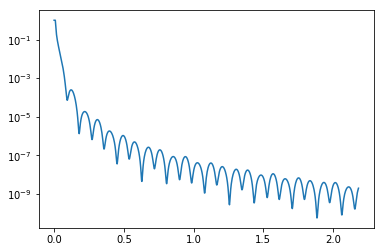

In [4]:
plt.semilogy(Q_VALUES,y)

In [5]:
kiesing_indices = []
crest_indices = []
for i in range(1,len(y)-1):
    y_1 = y[i-1]
    y0 = y[i]
    y1 = y[i+1]
    if( y_1 > y0 and y0 < y1 ):
        kiesing_indices.append(i)
    if( y_1 < y0 and y0 > y1 ):
        crest_indices.append(i)


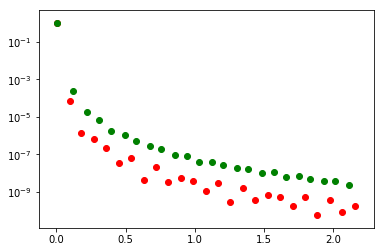

In [6]:
plt.semilogy(Q_VALUES,y,alpha=0.0)
plt.scatter(Q_VALUES[kiesing_indices],y[kiesing_indices],c='r')
plt.scatter(Q_VALUES[crest_indices],y[crest_indices],c='g')

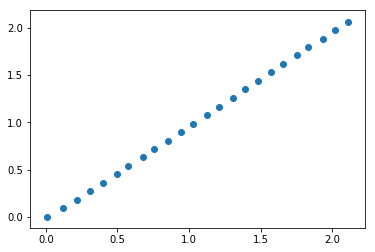

In [7]:
plt.scatter(Q_VALUES[crest_indices],Q_VALUES[kiesing_indices[:len(crest_indices)]])

highTiNi = Q_VALUES[crest_indices]
lowTiNi = Q_VALUES[kiesing_indices]

In [8]:
def run_two_slds(sld1,sld2):
    # set up the SLD objects for each layer
    sld_air = SLD(0.0 + 0.0j, name='air')
    sld_1 = SLD(sld1 + 0.0j, name='Ti')
    sld_2 = SLD(sld2 + 0.0j, name='Ni')
    sld_Si = SLD(2.0704 +  0.0j, name='Si')
    
    # set up the Slab objects for each layer
    slab_air = Slab(0.0, sld_air, 0.0, name='air_slab')
    slab_1 =  Slab(30.0, sld_1, 0.0, name ='Ti_slab')
    slab_2 =  Slab(70.0, sld_2, 0.0, name ='Ni_slab')
    slab_Si =  Slab(0.0, sld_Si, 0.0, name ='Si_slab')

    # set up the Structure object from the Slabs
    structure = Structure()
    
    structure.append(slab_air)
    for i in range(1):
        structure.append(slab_1)
        structure.append(slab_2)
    structure.append(slab_Si)
    
    reflectivity_values = refnx_reflectivity(structure,Q_VALUES)
    
    return reflectivity_values

In [9]:
s1 = -2.0
s2 =  9.0
r = run_two_slds(s1,s2)

In [396]:
def take_fingerprint(y):
    kiesing_indices = []
    crest_indices = []
    for i in range(1,len(y)-1):
        y_1 = y[i-1]
        y0 = y[i]
        y1 = y[i+1]
        if( y_1 > y0 and y0 < y1 ):
            kiesing_indices.append(i)
        if( y_1 < y0 and y0 > y1 ):
            crest_indices.append(i)
    return kiesing_indices, crest_indices

In [11]:
idx_low, idx_high = take_fingerprint(r)

In [12]:
low = Q_VALUES[idx_low]
high = Q_VALUES[idx_high]


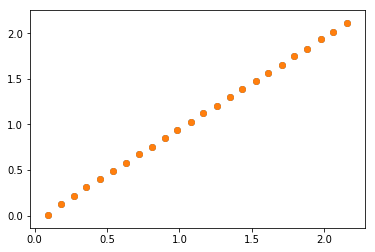

In [13]:
plt.scatter(low,high[1:])
plt.scatter(lowTiNi[1:],highTiNi)

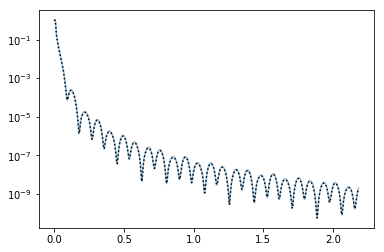

In [14]:
plt.semilogy(Q_VALUES,y, alpha=0.5)
plt.semilogy(Q_VALUES,r,'k:')

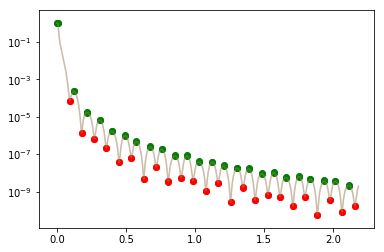

In [15]:
plt.semilogy(Q_VALUES,y,alpha=0.3)
plt.scatter(lowTiNi,y[kiesing_indices],c='r')
plt.scatter(highTiNi,y[crest_indices],c='g')

plt.semilogy(Q_VALUES,r,alpha=0.3)
plt.scatter(low,r[idx_low],c='r')
plt.scatter(high,r[idx_high],c='g')

In [16]:
print(low)
print(lowTiNi)

[0.09424013 0.17990852 0.27199259 0.35763919 0.45183109 0.53957805
 0.62943782 0.71926534 0.80691859 0.8988052  0.98637312 1.07816082
 1.16562547 1.25729545 1.34676841 1.43404453 1.52762869 1.61475488
 1.70816833 1.79512632 1.88411431 1.97512099 2.06179606 2.15681119]
[0.00428368 0.09424013 0.17990852 0.27199259 0.35763919 0.45183109
 0.53957805 0.62943782 0.71926534 0.80691859 0.8988052  0.98637312
 1.07816082 1.16562547 1.25729545 1.34676841 1.43404453 1.52762869
 1.61475488 1.70816833 1.79512632 1.88411431 1.97512099 2.06390885
 2.15681119]


In [17]:
def run_sld_thicknes_roughness(slds,thicknesses,roughnesses,qvals):
    assert len(slds) == len(thicknesses), "slds and thicknesses have different lengths"
    assert len(slds) == len(roughnesses), "slds and roughnesses have different lengths"
    
    structure = Structure()
    for i in range(len(slds)):
        m_sld = SLD(slds[i], name='sld'+str(i))
        slab = Slab(thicknesses[i], m_sld, roughnesses[i], name='slab'+str(i))
        structure.append(slab)
    
    reflectivity_values = refnx_reflectivity(structure,qvals)
    
    return reflectivity_values

# Single layer immersed in air:

In [118]:
def run_single_layer(s,th,q):
    slds = [0., s, 0]
    thicknesses = [0., th, 0.]
    roughnesses = [0.,  0., 0.]
    r = run_sld_thicknes_roughness(slds,thicknesses,roughnesses,q)
    return r

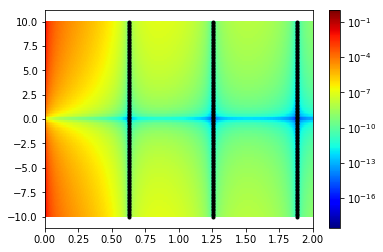

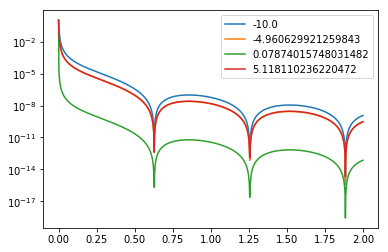

In [152]:
#Single Layer, varying SLD

qvals = np.linspace(0,2,1025)
refs = []
slds = []
fingerprints = {}
thickness = 10.
for sld in np.linspace(-10.,10.,128):
    slds.append(sld)
    ref = run_single_layer(sld,thickness,qvals)
    refs.append(ref)
    low, high = take_fingerprint(ref)
    fingerprints[sld] = qvals[low]
refs = np.asarray(refs)
slds = np.asarray(slds)
qvals = np.asarray(qvals)

import matplotlib.colors as colors
xx, yy = np.meshgrid(qvals, slds)
# Make the plot
plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=refs.min(), vmax=refs.max()), cmap='jet')
plt.colorbar()
for s in slds:
    plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.') 
plt.show()

for i in range(0,len(slds),len(slds)//4):
    plt.semilogy(qvals,refs[i], label = str(slds[i]))
plt.legend()
plt.show()


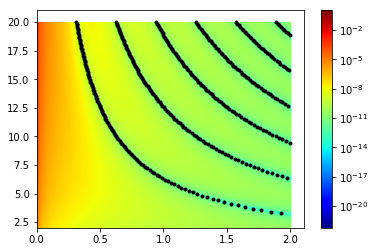

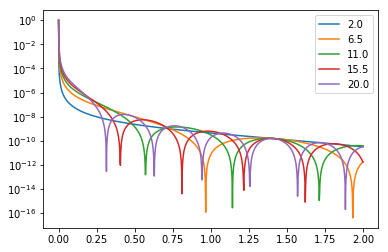

In [168]:
#Single Layer, varying thickness

qvals = np.linspace(0,2,1025)
refs = []
thicknesses = []
fingerprints = {}
sld = 1.
for thickness in np.linspace(2,20,129):
    thicknesses.append(thickness)
    ref = run_single_layer(sld,thickness,qvals)
    refs.append(ref)
    low, high = take_fingerprint(ref)
    fingerprints[thickness] = qvals[low]
refs = np.asarray(refs)
thicknesses = np.asarray(thicknesses)
qvals = np.asarray(qvals)

import matplotlib.colors as colors
xx, yy = np.meshgrid(qvals, thicknesses)
# Make the plot
plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=refs.min(), vmax=refs.max()), cmap='jet')
plt.colorbar()
for s in thicknesses:
    plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.') 
plt.show()

for i in range(0,len(thicknesses),len(thicknesses)//4):
    plt.semilogy(qvals,refs[i], label = str(thicknesses[i]))
plt.legend()
plt.show()

# Substrate only: semi-infinite slab

In [172]:
def run_substrate_only(s,th,q):
    slds = [0., s]
    thicknesses = [0., 0.]
    roughnesses = [0., 0.]
    r = run_sld_thicknes_roughness(slds,thicknesses,roughnesses,q)
    return r

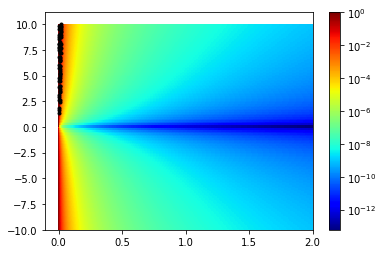

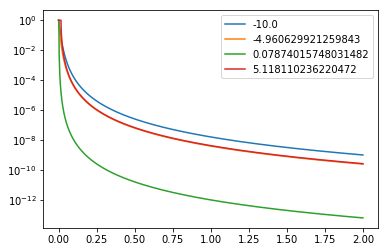

In [173]:
qvals = np.linspace(0,2,1025)
refs = []
slds = []
fingerprints = {}
thickness = 10.
for sld in np.linspace(-10.,10.,128):
    slds.append(sld)
    ref = run_substrate_only(sld,thickness,qvals)
    refs.append(ref)
    low, high = take_fingerprint(ref)
    fingerprints[sld] = qvals[low]
refs = np.asarray(refs)
slds = np.asarray(slds)
qvals = np.asarray(qvals)

import matplotlib.colors as colors
xx, yy = np.meshgrid(qvals, slds)
# Make the plot
plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=refs.min(), vmax=refs.max()), cmap='jet')
plt.colorbar()
for s in slds:
    plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.') 
plt.show()

for i in range(0,len(slds),len(slds)//4):
    plt.semilogy(qvals,refs[i], label = str(slds[i]))
plt.legend()
plt.show()

# Substrate + layer:

In [177]:
def run_layer_over_substrate(layer_sld, substrate_sld,layer_thickness,q):
    slds = [0., layer_sld, substrate_sld]
    thicknesses = [0., layer_thickness, 0.]
    roughnesses = [0.,  0., 0.]
    r = run_sld_thicknes_roughness(slds,thicknesses,roughnesses,q)
    return r

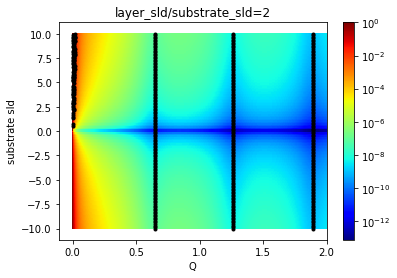

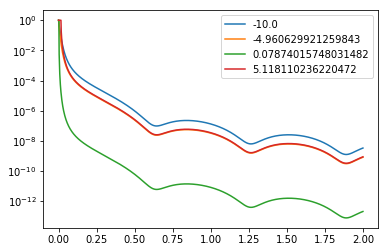

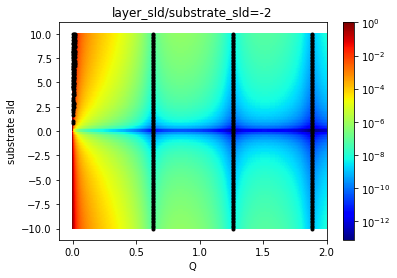

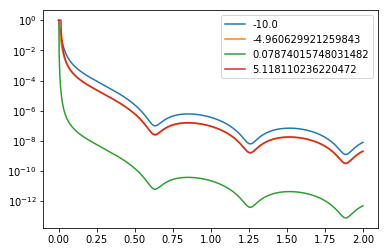

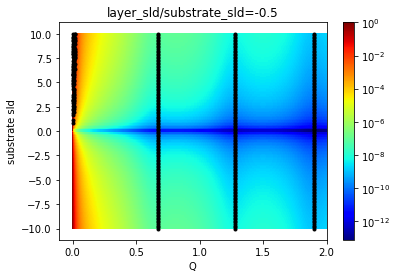

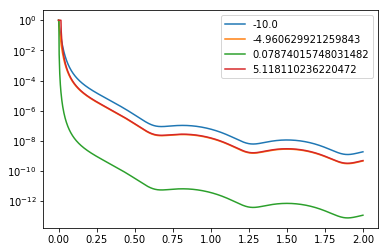

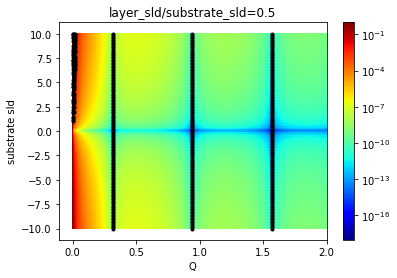

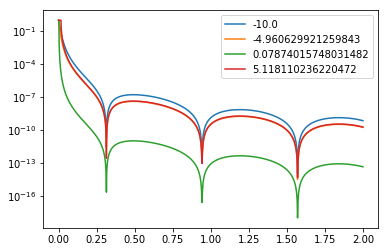

In [256]:
#Same thickness, varying sld:
def run_layer_over_substrate_with_sld_factor(factor):
    qvals = np.linspace(0,2,1025)
    refs = []
    slds = []
    fingerprints = {}
    thickness = 10.
    for sld in np.linspace(-10.,10.,128):
        slds.append(sld)
        ref = run_layer_over_substrate(factor*sld, sld,thickness,qvals)
        refs.append(ref)
        low, high = take_fingerprint(ref)
        fingerprints[sld] = qvals[low]
    refs = np.asarray(refs)
    slds = np.asarray(slds)
    qvals = np.asarray(qvals)
    
    import matplotlib.colors as colors
    xx, yy = np.meshgrid(qvals, slds)
    # Make the plot
    plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=refs.min(), vmax=refs.max()), cmap='jet')
    plt.colorbar()
    for s in slds:
        plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.') 
    plt.title("layer_sld/substrate_sld="+str(factor))
    plt.xlabel("Q")
    plt.ylabel("substrate sld")
    plt.show()
    
    for i in range(0,len(slds),len(slds)//4):
        plt.semilogy(qvals,refs[i], label = str(slds[i]))
    plt.legend()
    plt.show()
    
for f in [2,-2,-0.5,0.5]:
    run_layer_over_substrate_with_sld_factor(f)

In [381]:
qvals = np.linspace(0,5,1025)
thicknesses = np.linspace(1,20,129)

sld = 1.
for count, f in enumerate(np.linspace(-3.0,3.0,100)):
    
    refs = []
    fingerprints = {}
    for thickness in thicknesses:
        ref = run_layer_over_substrate(f*sld,sld,thickness,qvals)
        refs.append(ref)
        low, high = take_fingerprint(ref)
        fingerprints[thickness] = qvals[low]
    refs = np.asarray(refs)
    qvals = np.asarray(qvals)
    
    import matplotlib.colors as colors
    xx, yy = np.meshgrid(qvals, thicknesses)
    # Make the plot
    plt.figure()
    plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=1e-15, vmax=1.1), cmap='jet')
    plt.colorbar()
    for s in thicknesses:
        plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.', alpha=0.3) 
    plt.xlabel("Q")
    plt.ylabel("Thickness")
    plt.title("SLD Factor = " + str(f))
    plt.savefig("ConstantSLDfactorColormap_{:02}.png".format(count))
    #plt.show()
    plt.close(fig='all')
    
    plt.figure()
    for i in range(0,len(thicknesses),len(thicknesses)//4):
        plt.semilogy(qvals,refs[i], label = str(thicknesses[i]))
    
    multiplier = abs(1-f) * np.exp(abs(-f+f/2))
    plt.semilogy(qvals[1:],multiplier*(qvals[1:]/qvals[1])**-4,'k')
    plt.semilogy(qvals[1:],np.exp(-1.5)*(qvals[1:]/qvals[1])**-4,'k')
    plt.title("SLD Factor = " + str(f))
    plt.xlabel("Q")
    plt.ylabel("R")
    plt.legend()
    
    plt.savefig("ConstantSLDfactorRefCurve_{:02}.png".format(count))
    plt.close(fig='all')
    #plt.show()

In [336]:
qvals = np.linspace(0,5,1025)
sld = 1.

factors = np.concatenate([
    np.linspace(-3.,0.,128, endpoint=False),
    np.linspace(1.0/128.,1.,128, endpoint=False),
    np.linspace(1.,3.,128)
]
)

for count, thickness in enumerate(np.linspace(0.1,10,100)):

    refs = []
    fingerprints = {}
    for factor in factors:
        ref = run_layer_over_substrate(factor*sld,sld,thickness,qvals)
        refs.append(ref)
        low, high = take_fingerprint(ref)
        fingerprints[factor] = qvals[low]
    refs = np.asarray(refs)
    qvals = np.asarray(qvals)
    
    import matplotlib.colors as colors
    xx, yy = np.meshgrid(qvals, factors)
    # Make the plot
    
    plt.figure()
    plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=1e-15, vmax=1.1), cmap='jet')
    plt.colorbar()
    for s in factors:
        plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.', alpha=0.01) 
    plt.axhline(1.0, c='k', alpha=0.3)
    plt.axhline(0.0, c='k',alpha=0.3)
    plt.xlabel("$Q[\AA]$")
    plt.ylabel("f = layer sld / substrate sld")
    plt.title("Thickness = "+str(thickness))
    plt.savefig("ThicknessColorMap_{:02}.png".format(count))
    plt.close(fig='all')
    
    plt.figure()
    for i in range(0,len(factors)):
        if factors[i] < 0:
            plt.semilogy(qvals,1e-2*refs[i], "r", label = str(factors[i]))
        elif factors[i] < 1:
            plt.semilogy(qvals,1e-4*refs[i], "g", label = str(factors[i]))
        else:
            plt.semilogy(qvals,refs[i], "b", label = str(factors[i]))
    
    plt.xlabel("$Q[\AA]$")
    plt.ylabel("$R$")
    plt.title("Green: 0 < f < 1; Red: f < 0; Blue: f > 1; Th = "+str(thickness))
    plt.savefig("ThicknessRefCurve_{:02}.png".format(count))
    #plt.legend()
    plt.close(fig='all')

In [635]:
def run_layers_over_substrate(substrate_sld, layers_slds,layers_thicknesses,q):
    slds = [0.] + layers_slds + [substrate_sld]
    thicknesses = [0.] + layers_thicknesses + [0.]
    roughnesses = [0. for _ in thicknesses]
    r = run_sld_thicknes_roughness(slds,thicknesses,roughnesses,q)
    return r

# Self-Similarity of the problem:

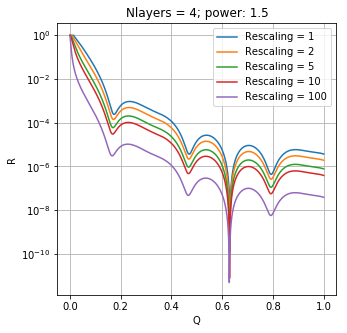

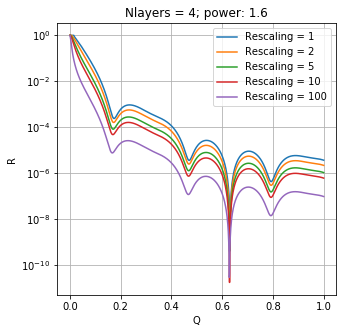

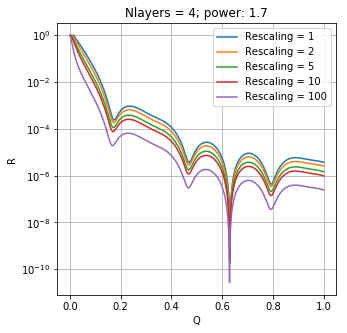

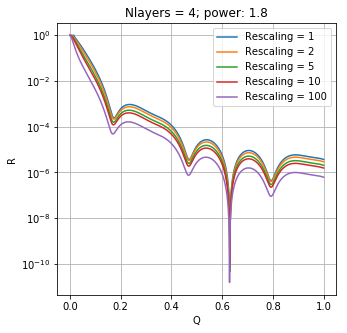

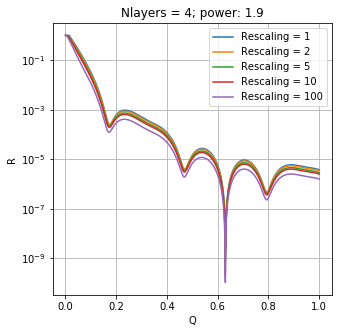

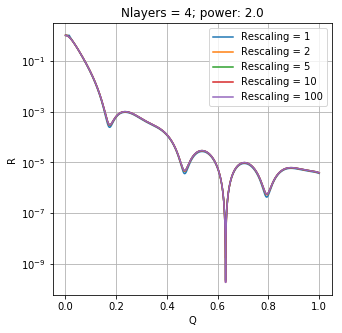

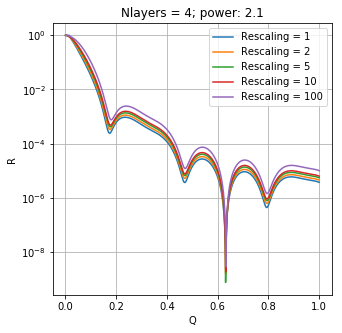

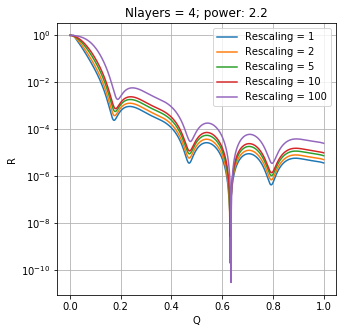

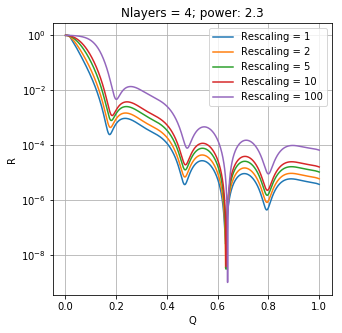

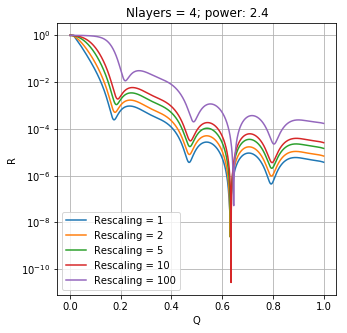

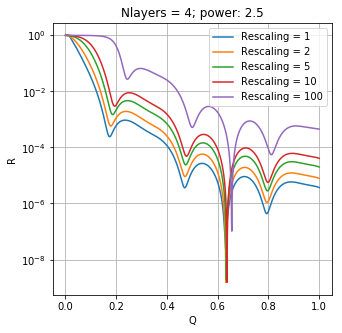

In [641]:
countfig = 0
power = 2.0
for substrate_sld in np.linspace(1.5,2.5,11):
    plt.figure(figsize=(5,5))
    for rescale in [1, 2, 5, 10, 100]:
        qvals = rescale * np.linspace(1e-3, 1.0, 1025)
        layers_slds = [10.0*x*(rescale**power) for x in [3,7,5,9]]
        layers_thicknesses = [(10.0 / rescale) for _ in layers_slds]
        
        
        
        ref_signal = run_layers_over_substrate(substrate_sld,layers_slds,layers_thicknesses,qvals)
        low, high = take_fingerprint(ref_signal)
        fingerprint = qvals[low]
    
        qvals /= rescale
        plt.semilogy(qvals,ref_signal, label = "Rescaling = " + str(rescale))
        #plt.semilogy(qvals,(2.0*rescale*qvals/layers_slds[0]/qvals[0])**-4,'k')
    
    
    plt.legend()
    plt.xlabel("Q")
    plt.ylabel("R")
    
    #plt.ylim([1e-7,1e-3])
    #plt.xlim([0.4,0.8])
    
    plt.title("Nlayers = " + str(len(layers_slds)) + "; power: " + str(power) )
    plt.grid()
    #plt.savefig("fig_{:02}.png".format(countfig))
    #plt.close(fig='all')
    plt.show()
    countfig+=1

# Map thickness vs SLD reflectometry for a single Q value

In [328]:
import matplotlib.colors as colors
for i, q in enumerate(np.linspace(0.1,2,100)):
    plt.figure()
    substrate_sld = 1.0
    factors = np.linspace(-3,3,64)
    thicknesses = np.linspace(1.0,10.0,64)
    roughnesses = np.zeros_like(slds)
    qvals = np.array([q])
    refs = np.array([[run_layer_over_substrate(f*substrate_sld,substrate_sld,t,qvals) for f in factors] for t in thicknesses])
    
    xx, yy = np.meshgrid(factors, thicknesses)
    refs = refs.reshape(xx.shape)
    
    
    # Make the plot
    plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=refs.min(), vmax=refs.max()), cmap='jet')
    plt.colorbar()
    #for s in thicknesses:
    #    plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.', alpha=0.3) 
    plt.xlabel("f = layer sld / substrate sld")
    plt.ylabel("Thickness")
    plt.title("Q="+str(q))
    plt.savefig("sld_factor_{:02}.png".format(i))
    plt.close(fig='all')

In [309]:
refs.shape

(129, 129)

In [321]:
for i in enumerate(np.linspace(0.1,10,10)):
    print(i[1])

0.1
1.2000000000000002
2.3000000000000003
3.4000000000000004
4.5
5.6
6.7
7.800000000000001
8.9
10.0


# Lessons learned:

## For a single layer over a substrate:

The substrate has an SLD $SLD_s$ and the layer over it has an $SLD_l = f \, SLD_s$.
 - Vary sld factor $f$ --> Varies the "amplitude" of the kiessing finges; the "frequency" stays the same.
  - $f$ between 0 and 1 invert the position of the peaks/crests; the effect being strongest for $f = 0.5$
  - For $f = 0$ and $f = 1$, the signal has no bumps
  - The signal has two envelope curves of a functional form $ ~ Q^{-4} \, g(f)\, e^{-1.5 \, h(f)}$
 - Vary thickness --> Varies the "frequency" of kiessing fringes, while the "amplitude" stays the same.
 
## Problem scaling -- Self-similarity (applies for any number of layers):

Letting the "natural" unit of the problem to be the $Q$ range, and rescaling it by a factor $\alpha$:

 - $Q_\alpha = \alpha\, Q$,

the same reflectometry signal is obtained if, at the same time, the following scalings are performed:

 - $\{\rho_i\}_\alpha = \{\alpha^2 \, \rho_i\}$
 - $\{d_i\}_\alpha = \alpha^{-1} \, d_i $

where $\rho_i$ and $d_i$ are the SLD and the thickness of the set of layers.
 


